# XGBoost Model

In [2]:
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

### Plotting functions

In [3]:
# helper function
import matplotlib.pyplot as plt

def plot_train_val_losses(eval_scores):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for fold in range(5):
        fold_scores = eval_scores[fold]
        axes[fold].plot(fold_scores['validation_0']['rmse'], label="Train Loss")
        axes[fold].plot(fold_scores['validation_1']['rmse'], label="Validation Loss")
        axes[fold].set_title(f"Fold {fold+1}")
        axes[fold].set_xlabel("Boosting Rounds")
        axes[fold].set_ylabel("RMSE Loss")
        axes[fold].legend()
    
    plt.tight_layout()
    plt.show()

In [4]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted Ki Values")
    plt.show()

In [62]:
def plot_residuals(y_test, y_pred):
    residuals = np.squeeze(y_test) - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Ki Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot of Ki Values")
    plt.show()

#### Hyperparameter tuning  and regularization with RandomizedSearchCV

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [64]:
def hyperparam_search(X_train, y_train):
    param_dist = {
        'learning_rate': uniform(0.001, 0.2),
        'max_depth': randint(3, 10),
        'n_estimators': randint(50, 400),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_alpha': uniform(0, 1), # L1 regularization
        'reg_lambda': uniform(0, 10) # L2 regularization
    }

    xgb = XGBRegressor(random_state=42)

    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=20,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    print("Best hyperparameters found:", best_params)
    return best_params

#### K-Fold Cross-Validation

In [65]:
def KFold_CV(X_train, y_train, best_params):

    # 5 fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    train_mse_scores = []
    val_mse_scores = []
    eval_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_in, X_val = X_train[train_idx], X_train[val_idx] 
        y_train_in, y_val = y_train[train_idx], y_train[val_idx]

        xgb_model = XGBRegressor(
            **best_params,
            random_state=42,
            eval_metric="rmse",
            early_stopping_rounds=10,
            n_jobs=-1
        )

        xgb_model.fit(
            X_train_in,
            y_train_in,
            eval_set= [(X_train_in, y_train_in), (X_val, y_val)], #[(X_val, y_val)],
            verbose=False,
        )

        evals_result = xgb_model.evals_result()
        eval_scores.append(evals_result)

        y_train_pred = xgb_model.predict(X_train_in)
        y_val_pred = xgb_model.predict(X_val)

        train_mse = mean_squared_error(y_train_in, y_train_pred)
        train_mse_scores.append(train_mse)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_mse_scores.append(val_mse)

        print(f"Fold {fold + 1} — Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
        
    plot_train_val_losses(eval_scores)

    print(f"Average Train MSE: {np.mean(train_mse_scores):.4f} ± {np.std(train_mse_scores):.4f}")
    print(f"Average Validation MSE: {np.mean(val_mse_scores):.4f} ± {np.std(val_mse_scores):.4f}")

#### Test Function

In [66]:
def test_model(X_train, y_train, X_test, y_test, best_params):
    # remake new model on best params
    xgb_model = XGBRegressor(
        **best_params,
        random_state=42,
        eval_metric="rmse",
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train) # Re-fit on all training data
    y_test_pred = xgb_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    plot_actual_vs_predicted(y_test, y_test_pred)
    plot_residuals(y_test, y_test_pred)

    print(f"Final Test MSE: {test_mse:.4f}")
    print(f"Final Test R²: {test_r2:.4f}")
    return xgb_model

## Training, Validation, and Testing

### Dataset 1: Using RDKit Feature Data

In [67]:
import pickle

In [68]:
# import RDKit features data
with open("data_splits.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [69]:
# Use RandomizedSearchCV to find best hyperparameters
best_params = hyperparam_search(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found: {'colsample_bytree': np.float64(0.6092249700165663), 'learning_rate': np.float64(0.10595493205167783), 'max_depth': 9, 'n_estimators': 219, 'reg_alpha': np.float64(0.04666566321361543), 'reg_lambda': np.float64(9.737555188414591), 'subsample': np.float64(0.6931085361721216)}


Fold 1 — Train MSE: 0.4026, Validation MSE: 0.7395
Fold 2 — Train MSE: 0.4069, Validation MSE: 0.6583
Fold 3 — Train MSE: 0.4082, Validation MSE: 0.7605
Fold 4 — Train MSE: 0.3939, Validation MSE: 0.5512
Fold 5 — Train MSE: 0.4441, Validation MSE: 0.4954


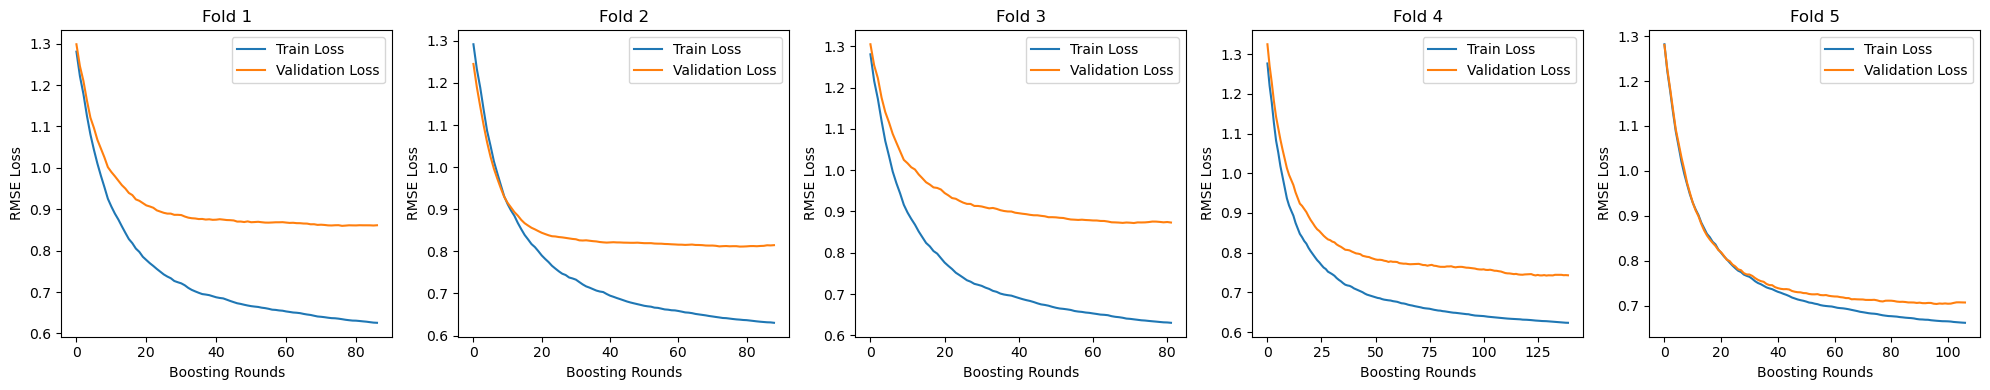

Average Train MSE: 0.4111 ± 0.0172
Average Validation MSE: 0.6410 ± 0.1035


In [70]:
# Train and validate with cross-validation
KFold_CV(X_train, y_train, best_params)

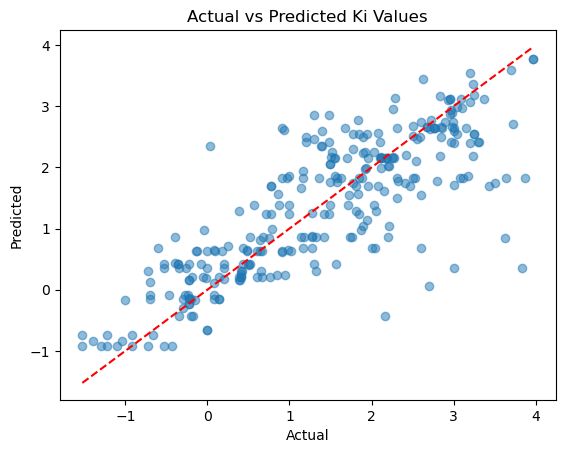

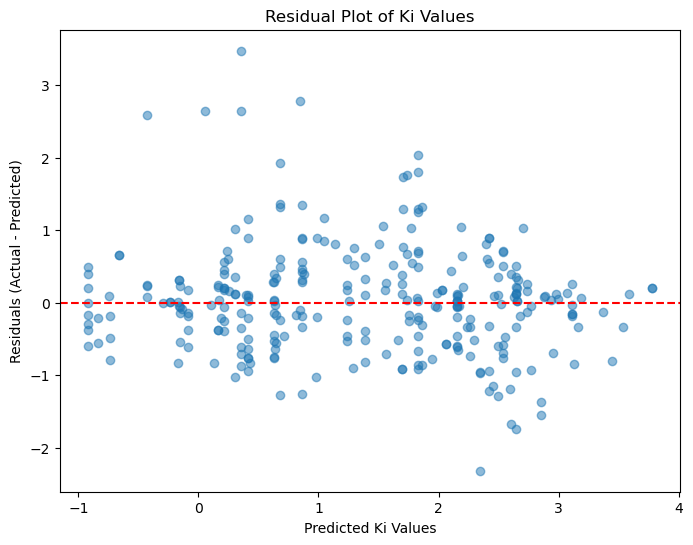

Final Test MSE: 0.5567
Final Test R²: 0.6651


In [71]:
# Test model on unseen data
xgb_model = test_model(X_train, y_train, X_test, y_test, best_params)

[0.22391619 0.10513309 0.14538611 0.16382118 0.19461149 0.16713195]


<Figure size 800x1200 with 0 Axes>

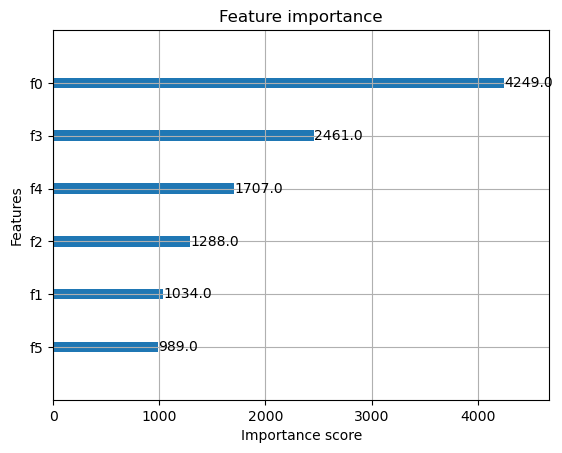

In [72]:
feat_imps = xgb_model.feature_importances_
print(feat_imps)
plt.figure(figsize=(8, 12))
xgboost.plot_importance(xgb_model)
plt.show()

### Dataset 2: Using Morgan Fingerprint Data

In [73]:
# import morgan fingerprint data
with open("data_splits_fps.pkl", "rb") as f:
    X_train_fps, X_test_fps, y_train_fps, y_test_fps = pickle.load(f)

In [74]:
# Use RandomizedSearchCV to find best hyperparameters
best_params_fps = hyperparam_search(X_train_fps, y_train_fps)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found: {'colsample_bytree': np.float64(0.6362425738131283), 'learning_rate': np.float64(0.12467720186661746), 'max_depth': 6, 'n_estimators': 104, 'reg_alpha': np.float64(0.9832308858067882), 'reg_lambda': np.float64(4.667628932479799), 'subsample': np.float64(0.9439761626945282)}


Fold 1 — Train MSE: 0.3576, Validation MSE: 0.6592
Fold 2 — Train MSE: 0.4098, Validation MSE: 0.5835
Fold 3 — Train MSE: 0.3754, Validation MSE: 0.7585
Fold 4 — Train MSE: 0.4210, Validation MSE: 0.5767
Fold 5 — Train MSE: 0.4145, Validation MSE: 0.4297


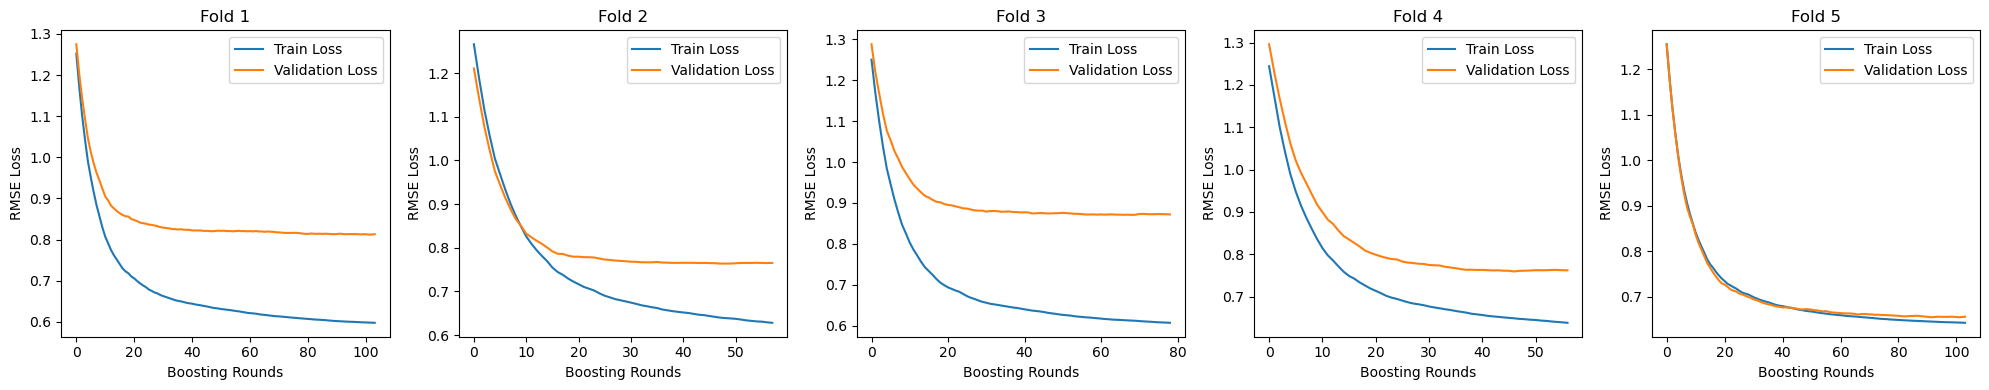

Average Train MSE: 0.3957 ± 0.0247
Average Validation MSE: 0.6015 ± 0.1081


In [75]:
# Train and validate with cross-validation
KFold_CV(X_train_fps, y_train_fps, best_params_fps)

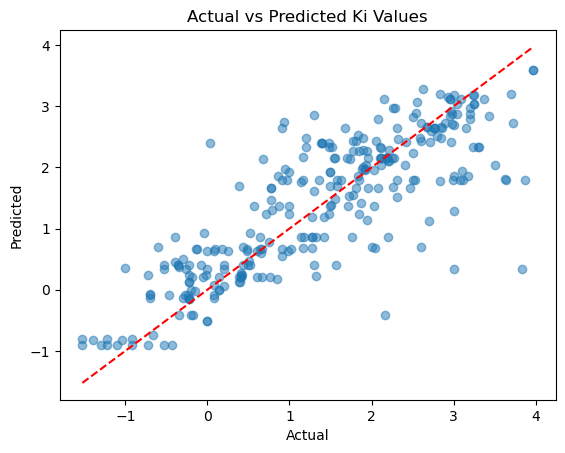

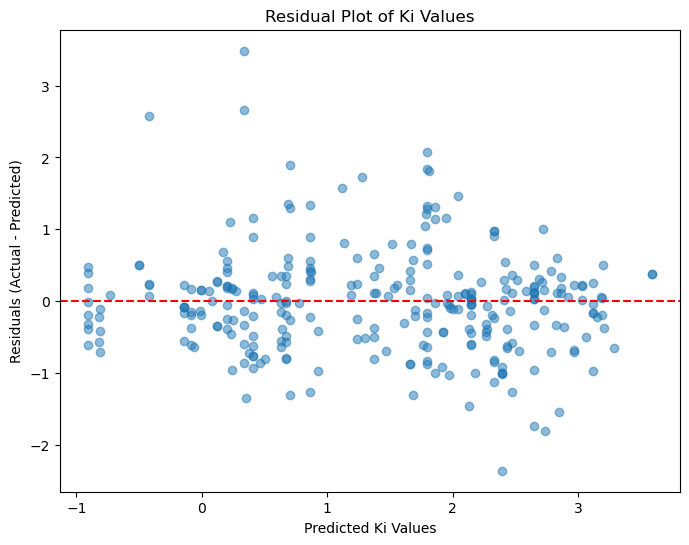

Final Test MSE: 0.5190
Final Test R²: 0.6878


In [76]:
# Test model on unseen data
xgb_model_fps = test_model(X_train_fps, y_train_fps, X_test_fps, y_test_fps, best_params_fps)

<Figure size 800x1200 with 0 Axes>

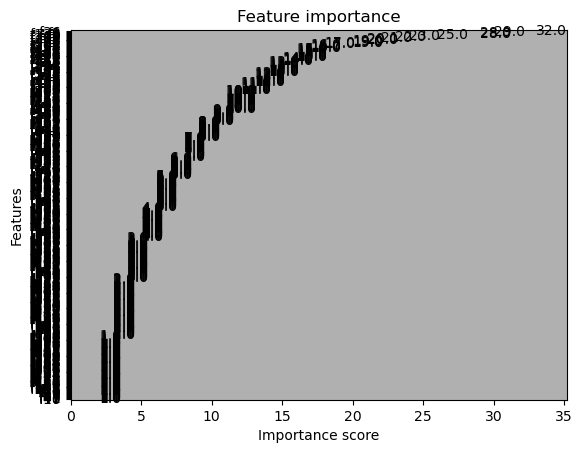

In [77]:
feat_imps_fps = xgb_model_fps.feature_importances_
plt.figure(figsize=(8, 12))
xgboost.plot_importance(xgb_model_fps)
plt.show()

#### Manual hyperparameter tuning

Fold 1 — Train MSE: 0.4196, Validation MSE: 0.6865
Fold 2 — Train MSE: 0.4282, Validation MSE: 0.5740
Fold 3 — Train MSE: 0.3991, Validation MSE: 0.7785
Fold 4 — Train MSE: 0.4280, Validation MSE: 0.5878
Fold 5 — Train MSE: 0.4278, Validation MSE: 0.4302


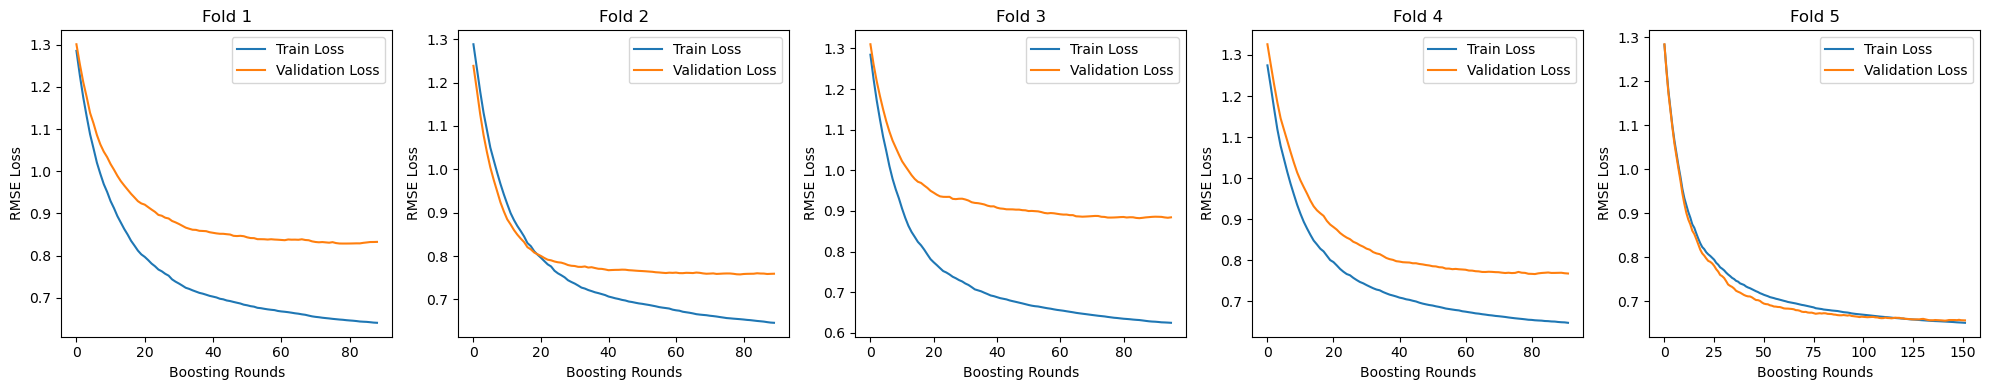

Average Train MSE: 0.4205 ± 0.0112
Average Validation MSE: 0.6114 ± 0.1169


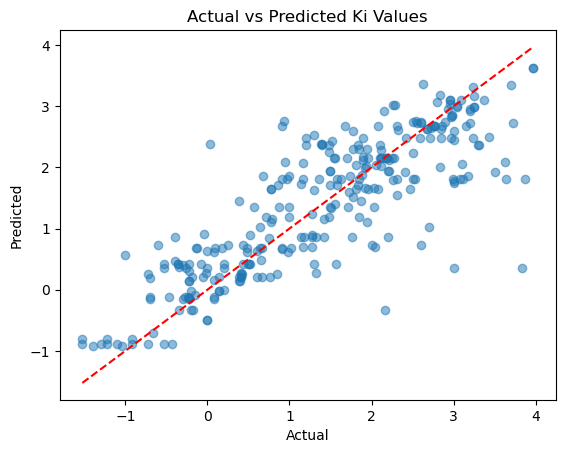

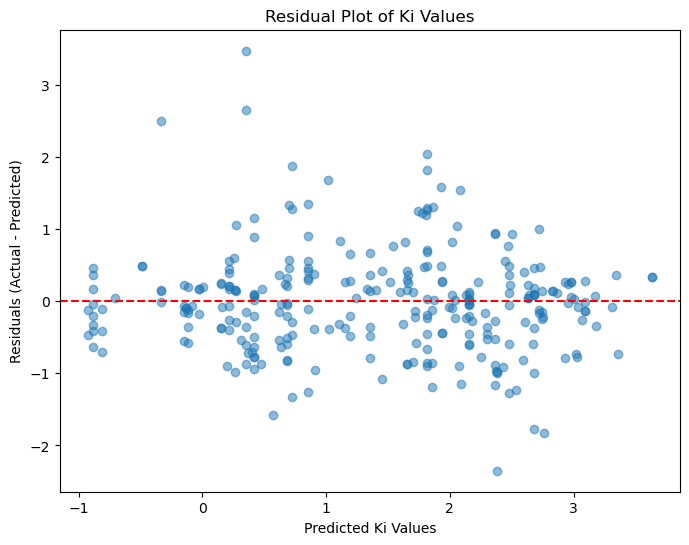

Final Test MSE: 0.4992
Final Test R²: 0.6997


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [86]:
# Decreasing max depth
params1 = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.046, # L1 regularization
    'reg_lambda': 9.74 # L2 regularization
}
KFold_CV(X_train_fps, y_train_fps, params1)
test_model(X_train_fps, y_train_fps, X_test_fps, y_test_fps, params1)

Fold 1 — Train MSE: 0.3970, Validation MSE: 0.6649
Fold 2 — Train MSE: 0.4581, Validation MSE: 0.5784
Fold 3 — Train MSE: 0.3976, Validation MSE: 0.7845
Fold 4 — Train MSE: 0.4097, Validation MSE: 0.5734
Fold 5 — Train MSE: 0.4372, Validation MSE: 0.4476


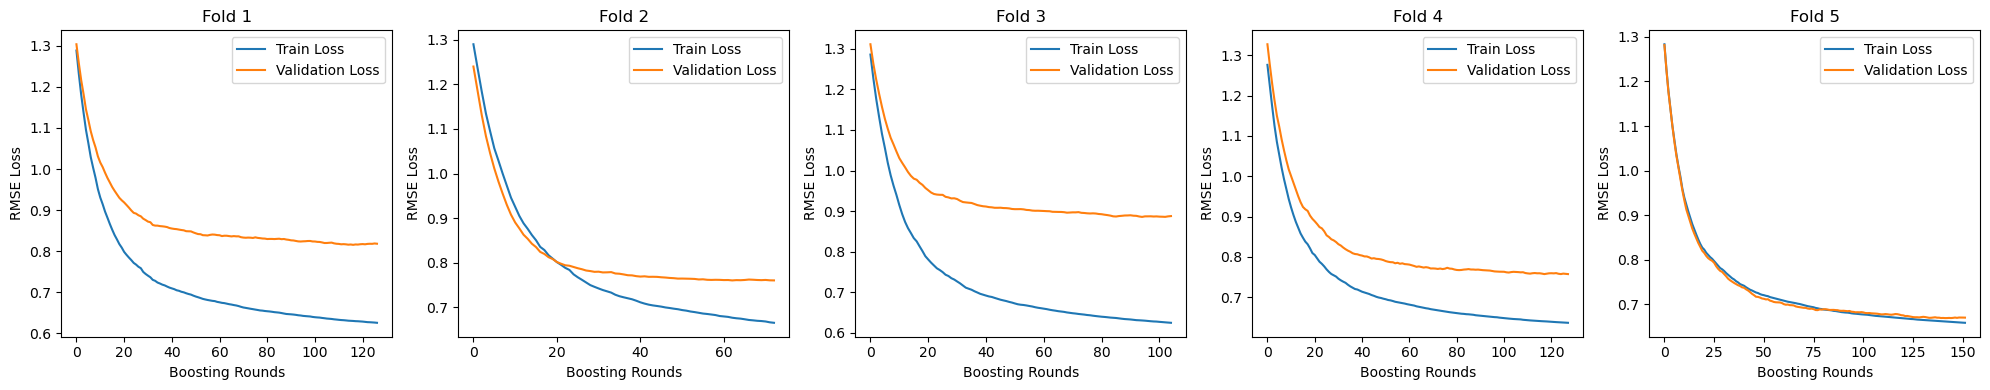

Average Train MSE: 0.4199 ± 0.0240
Average Validation MSE: 0.6097 ± 0.1115


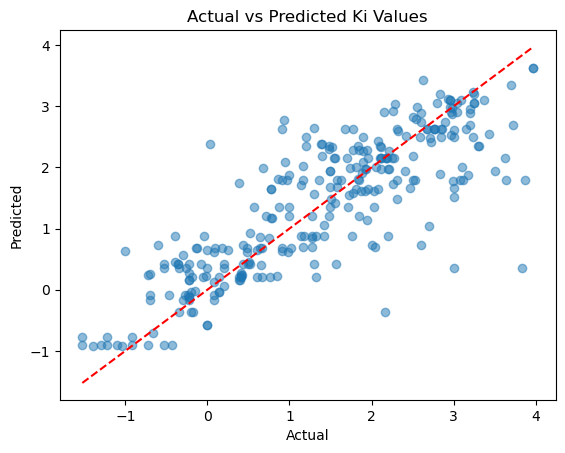

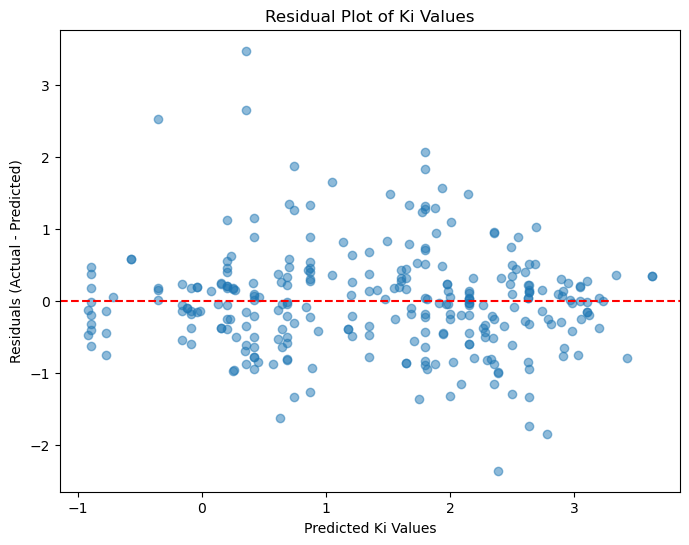

Final Test MSE: 0.5098
Final Test R²: 0.6933


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [79]:
# Increase regularization (reg_alpha, reg_lambda)
params2 = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.4, # L1 regularization
    'reg_lambda': 12 # L2 regularization
}
KFold_CV(X_train_fps, y_train_fps, params2)
test_model(X_train_fps, y_train_fps, X_test_fps, y_test_fps, params2)

Fold 1 — Train MSE: 0.4125, Validation MSE: 0.6801
Fold 2 — Train MSE: 0.4041, Validation MSE: 0.5724
Fold 3 — Train MSE: 0.4080, Validation MSE: 0.7872
Fold 4 — Train MSE: 0.4489, Validation MSE: 0.5927
Fold 5 — Train MSE: 0.4512, Validation MSE: 0.4479


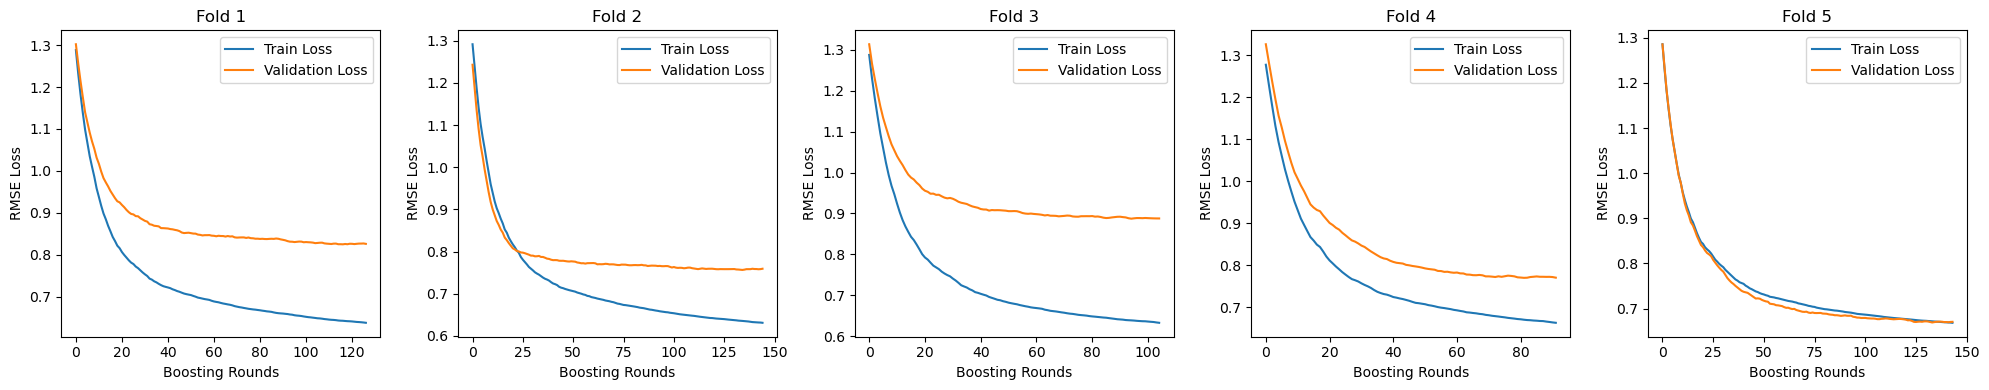

Average Train MSE: 0.4249 ± 0.0207
Average Validation MSE: 0.6160 ± 0.1132


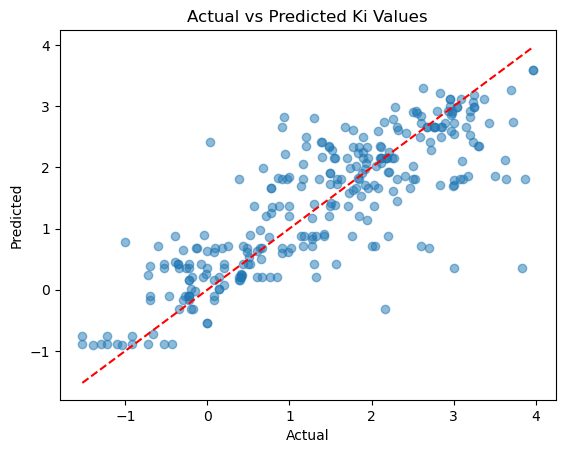

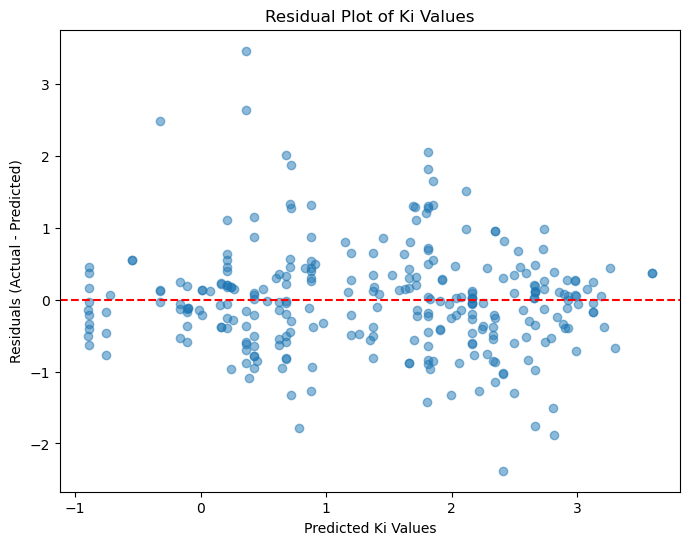

Final Test MSE: 0.5226
Final Test R²: 0.6857


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [80]:
# Add min_child_weight
params3 = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.4, # L1 regularization
    'reg_lambda': 12, # L2 regularization
    'min_child_weight': 5
}
KFold_CV(X_train_fps, y_train_fps, params3)
test_model(X_train_fps, y_train_fps, X_test_fps, y_test_fps, params3)

Fold 1 — Train MSE: 0.4083, Validation MSE: 0.6612
Fold 2 — Train MSE: 0.4355, Validation MSE: 0.5787
Fold 3 — Train MSE: 0.4187, Validation MSE: 0.8144
Fold 4 — Train MSE: 0.4334, Validation MSE: 0.5799
Fold 5 — Train MSE: 0.4499, Validation MSE: 0.4436


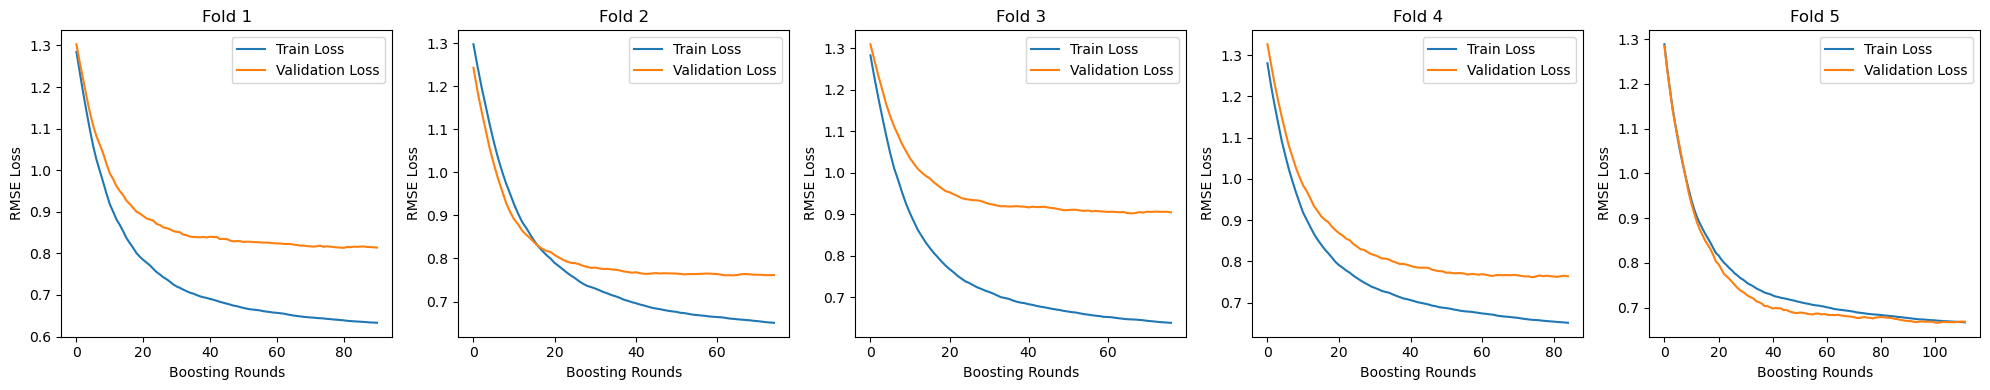

Average Train MSE: 0.4292 ± 0.0143
Average Validation MSE: 0.6156 ± 0.1215


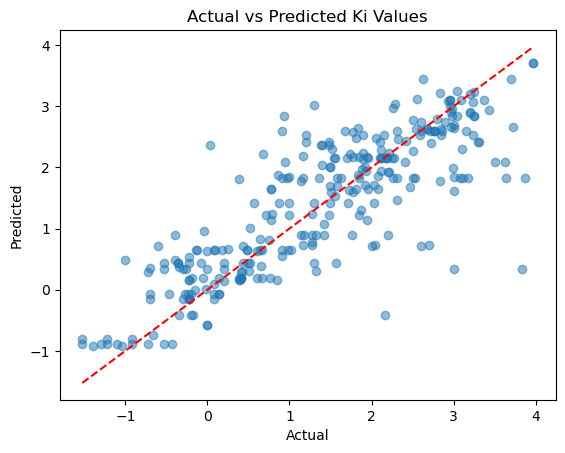

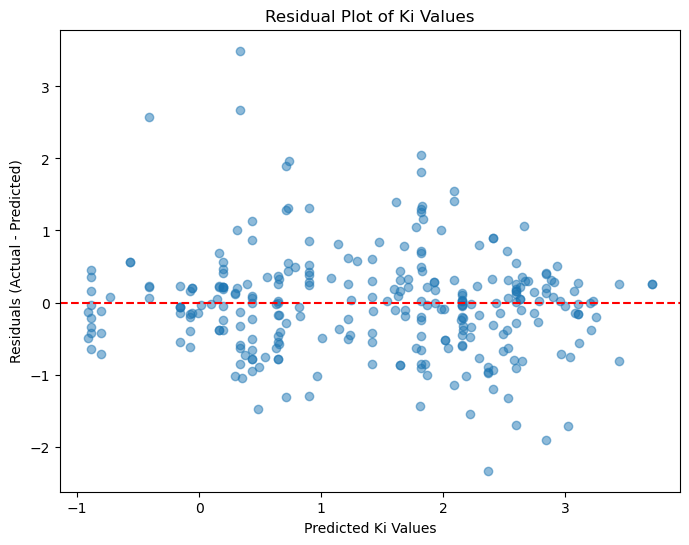

Final Test MSE: 0.5142
Final Test R²: 0.6907


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [81]:
# Decreasing sampling (sub_sample, colsample_bytree)
params4 = {
    'learning_rate': 0.1,
    'max_depth': 9,
    'n_estimators': 200,
    'subsample': 0.5,
    'colsample_bytree': 0.4,
    'reg_alpha': 0.4, # L1 regularization
    'reg_lambda': 12, # L2 regularization
    'min_child_weight': 5
}
KFold_CV(X_train_fps, y_train_fps, params4)
test_model(X_train_fps, y_train_fps, X_test_fps, y_test_fps, params4)

#### Drop least important features

In [82]:
threshold = 0.005
important_indices = np.where(feat_imps_fps > threshold)[0]

print(f"Keeping {len(important_indices)} features out of {X_train_fps.shape[1]}")

X_train_reduced = X_train_fps[:, important_indices]
X_test_reduced = X_test_fps[:, important_indices]


Keeping 44 features out of 512


Fold 1 — Train MSE: 0.4565, Validation MSE: 0.6705
Fold 2 — Train MSE: 0.5460, Validation MSE: 0.6353
Fold 3 — Train MSE: 0.4433, Validation MSE: 0.7559
Fold 4 — Train MSE: 0.4862, Validation MSE: 0.6028
Fold 5 — Train MSE: 0.5300, Validation MSE: 0.4691


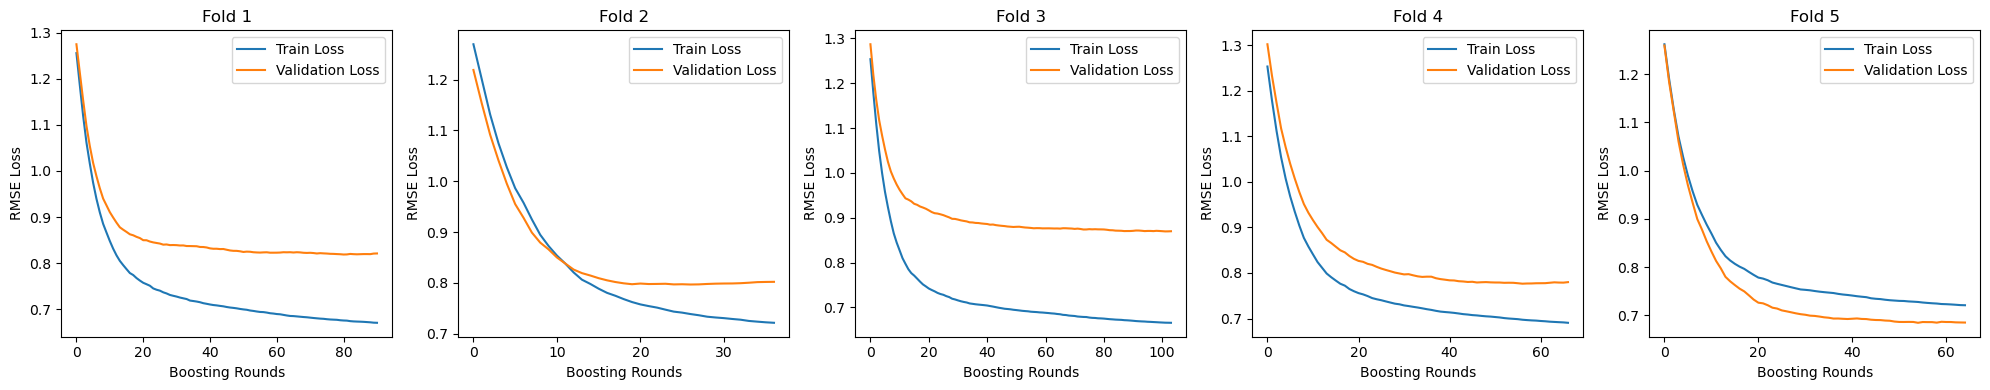

Average Train MSE: 0.4924 ± 0.0401
Average Validation MSE: 0.6267 ± 0.0939


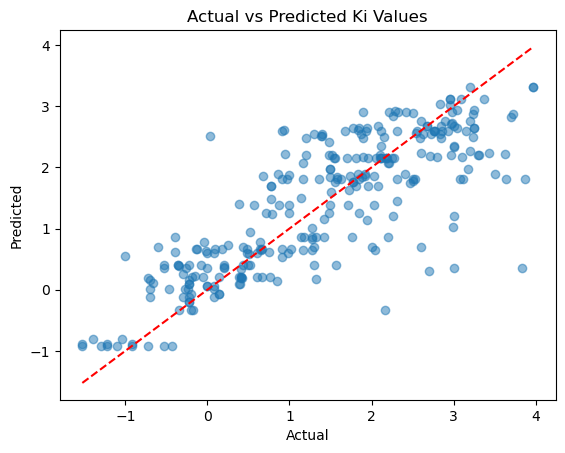

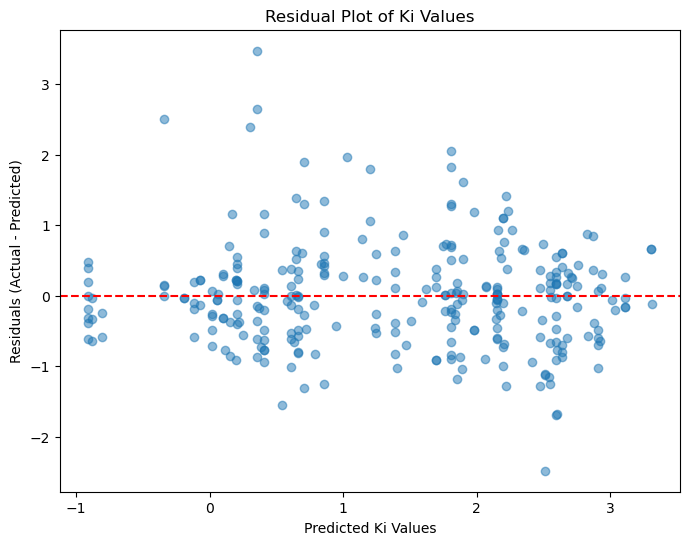

Final Test MSE: 0.5536
Final Test R²: 0.6670


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.6362425738131283), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None,
             learning_rate=np.float64(0.12467720186661746), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=104, n_jobs=-1,
             num_parallel_tree=None, ...)

In [83]:
KFold_CV(X_train_reduced, y_train_fps, best_params_fps)
test_model(X_train_reduced, y_train_fps, X_test_reduced, y_test_fps, best_params_fps)

### Final Summary of results:

#### Best Average Train MSE achieved with RandomizedSearchCV hyperparameters:  
Average Train MSE: 0.3957 ± 0.0247  
Average Validation MSE: 0.6015 ± 0.1081  
Final Test MSE: 0.5190  
Final Test R²: 0.6878  
  
#### Best Test MSE achieved by manually decreasing max_depth from 6 to 5:  
Average Train MSE: 0.4205 ± 0.0112  
Average Validation MSE: 0.6114 ± 0.1169  
Final Test MSE: 0.4992  
Final Test R²: 0.6997  